<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 25px; border-radius: 15px; color: white; margin: 20px 0; box-shadow: 0 8px 16px rgba(0,0,0,0.2);">
<h1 style="color: white; text-align: center;">🏠 Проект: Предсказание цены на дом</h1>
<hr style="border-color: white;">

<div style="background: rgba(255,255,255,0.1); padding: 15px; border-radius: 10px; margin: 15px 0;">
<h3 style="color: white;">📋 Описание задачи</h3>
<p>Построение модели машинного обучения для точного предсказания стоимости жилой недвижимости на основе характеристик объектов. Используем передовые алгоритмы бустинга.</p>
</div>

<div style="display: flex; justify-content: space-around; flex-wrap: wrap;">
<div style="background: rgba(255,255,255,0.2); padding: 10px; border-radius: 8px; margin: 5px; flex: 1;">
<strong>📊 Данные:</strong> 1460 наблюдений, 80+ признаков
</div>
<div style="background: rgba(255,255,255,0.2); padding: 10px; border-radius: 8px; margin: 5px; flex: 1;">
<strong>🎯 Метрика:</strong> RMSLE
</div>
<div style="background: rgba(255,255,255,0.2); padding: 10px; border-radius: 8px; margin: 5px; flex: 1;">
</div>
</div>
</div>

In [40]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_log_error, make_scorer
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import numpy as np

In [4]:
train = pn.read_csv('train.csv')
test = pn.read_csv('test.csv')
example = pn.read_csv('sample_submission.csv')

print(f"Раземеры выборки: {train.shape}")

number_f = train.select_dtypes(exclude='object').columns # числовые признаки
cateforical_f = train.select_dtypes(include='object').columns # категориальные признаки

Раземеры выборки: (1460, 81)


<div style="background: linear-gradient(135deg, #f093fb 0%, #f5576c 100%); padding: 20px; border-radius: 15px; color: white; margin: 20px 0;">
<h2 style="color: white;"> Анализ данных и исследовательский анализ</h2>
</div>

In [5]:
'''plt.figure(figsize=(20, 20))
sns.heatmap(train[number_f].corr(method='pearson'), annot=True, cmap='coolwarm')'''

"plt.figure(figsize=(20, 20))\nsns.heatmap(train[number_f].corr(method='pearson'), annot=True, cmap='coolwarm')"

<h2>Пропуски в данных</h2>

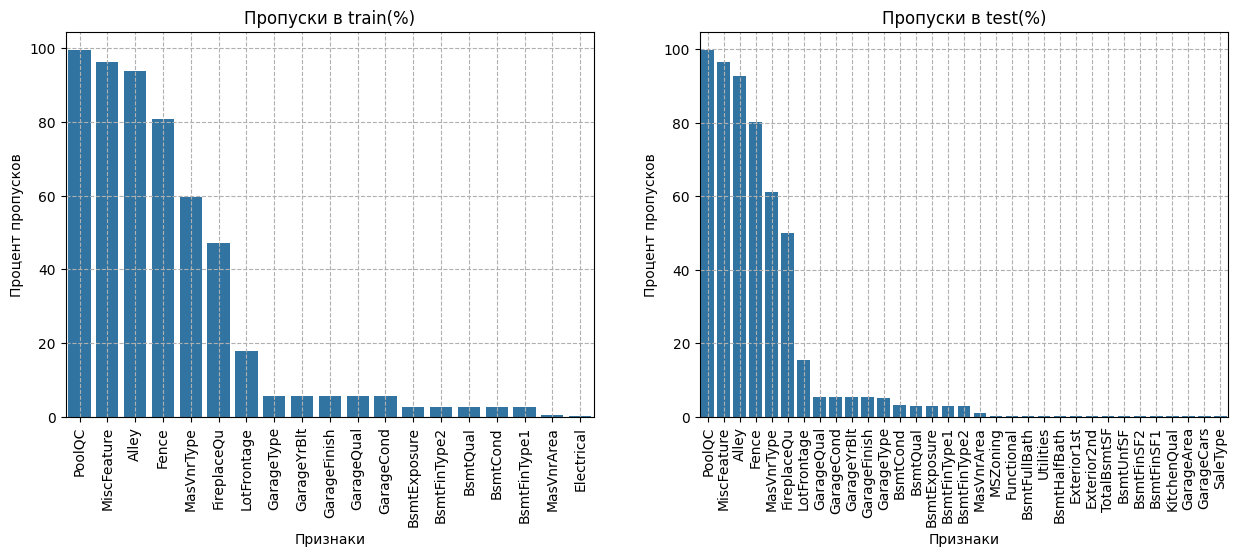

In [6]:
miss_train = train.isna().sum() / train.shape[0] * 100
miss_train = miss_train[miss_train > 0].sort_values(ascending=False)

miss_test = test.isna().sum() / test.shape[0] * 100
miss_test = miss_test[miss_test > 0].sort_values(ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

sns.barplot(x=miss_train.index, y=miss_train, ax=ax[0])
sns.barplot(x=miss_test.index, y=miss_test, ax=ax[1])

ax[0].set_title('Пропуски в train(%)')
ax[1].set_title('Пропуски в test(%)')

for axes in ax:
  axes.tick_params(axis='x', rotation=90)
  axes.grid(True, linestyle='--')
  axes.set_xlabel('Признаки')
  axes.set_ylabel('Процент пропусков')

plt.show()

<div style="background: linear-gradient(135deg, #4facfe 0%, #00f2fe 100%); padding: 20px; border-radius: 15px; color: white; margin: 20px 0;">
<h2 style="color: white;"> Обработка данных и feature engineering</h2>
</div>

In [7]:
def preprocessing(df):
  df = df.copy()

  df = df.drop(['Alley', 'MiscFeature'], axis=1)

  # Многие критерии имеют оценку качества, так что сделаем очевидные преобразования
  common_marks = ['BsmtQual', 'BsmtCond', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'HeatingQC']
  for i in common_marks:
    df[i] = df[i].map({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}).fillna(0)

  df['GarageFinish'] = df['GarageFinish'].map({'Fin': 3, 'RFn': 2, 'Unf': 1}).fillna(0)

  df['BsmtFinType1'] = df['BsmtFinType1'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1}).fillna(0)
  df['BsmtFinType2'] = df['BsmtFinType2'].map({'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1}).fillna(0)

  # Взвешанный показатель качества отделки подвала
  df['BsmtFinTotal'] = ((df['BsmtFinSF1'] * df['BsmtFinType1'] + df['BsmtFinSF2'] * df['BsmtFinType2']) / (df['BsmtFinSF1'] + df['BsmtFinSF2'])).fillna(0)

  df['GarageYrBlt'] = (df['YrSold'] - df['GarageYrBlt']).fillna(0) # возраст гаража, ошибка ли менять возраст гаража на ноль, если его нет...
  df['YearBuilt'] = df['YrSold'] - df['YearBuilt'] # возраст дома

  df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median()) # пока затычка

  # Логично предположить, что чем меньше функций, тем хуже
  df['Utilities'] = df['Utilities'].map({'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1}).fillna(0)

  # Предпологается типичная функциональность
  df['Functional'] = df['Functional'].fillna('Typ')
  # Многие признаки имеют Nan, если это отсутствует у них(площадь 2 этажа, качество подвала...), поэтому ноль(см. data_description)
  df = df.drop(['BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF2', 'YrSold', 'GarageCars'], axis=1).fillna(0)

  # 'Exterior1st', 'Exterior2nd',

  return df

pre_train = preprocessing(train)
f_train = pn.get_dummies(pre_train)

<div style="background: linear-gradient(135deg, #43e97b 0%, #38f9d7 100%); padding: 20px; border-radius: 15px; color: white; margin: 20px 0;">
<h2 style="color: white;"> Обучение моделей </h2>
</div>

In [43]:
X_train, X_test, y_train, y_test = train_test_split(f_train.drop(['SalePrice', 'Id'], axis=1), f_train['SalePrice'], test_size=0.3, random_state=42)
result = {}

In [44]:
RandomForest_params = {
    'n_estimators': 541,
    'min_samples_split': 4,
    'min_samples_leaf': 2
}

model = RandomForestRegressor(**RandomForest_params)
model.fit(X_train, y_train)
ans = root_mean_squared_log_error(y_test, model.predict(X_test))
result['RandomForest'] = ans
print(f'RMSLE: {ans}')

RMSLE: 0.13988629528799368


In [48]:
GradientBoosting_params = {
    'n_estimators': 778,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 5,
    'learning_rate': 0.028008510678726395
}

model = GradientBoostingRegressor(**GradientBoosting_params)
model.fit(X_train, y_train)
ans = root_mean_squared_log_error(y_test, model.predict(X_test))
result['GradientBoosting'] = ans
print(f'RMSLE: {ans}')

RMSLE: 0.12683247585089719


In [49]:
X_train, X_test, y_train, y_test = train_test_split(pre_train.drop(['SalePrice', 'Id'], axis=1), pre_train['SalePrice'], test_size=0.3, random_state=42)
cat_f = X_train.select_dtypes(include=['object']).columns.to_list()

train_pool = Pool(X_train, y_train, cat_features=cat_f)
val_pool = Pool(X_test, y_test, cat_features=cat_f)

CatBoost_params = {
    'iterations': 1000,
    'learning_rate': 0.03,
    'depth': 6,
    'loss_function':'RMSE',
    'eval_metric': 'RMSE'
}

model = CatBoostRegressor(**CatBoost_params)
model.fit(train_pool, eval_set=val_pool, use_best_model=True, verbose=100)
ans = root_mean_squared_log_error(y_test, model.predict(X_test))
result['CatBoost'] = ans
print(f'RMSLE: {ans}')

0:	learn: 76217.4578629	test: 82180.2073628	best: 82180.2073628 (0)	total: 29.1ms	remaining: 29.1s
100:	learn: 26648.1381865	test: 31930.1835710	best: 31930.1835710 (100)	total: 2.93s	remaining: 26.1s
200:	learn: 19694.7963342	test: 26183.9934086	best: 26183.9934086 (200)	total: 5.63s	remaining: 22.4s
300:	learn: 16665.4525058	test: 24512.5518381	best: 24512.5518381 (300)	total: 9.06s	remaining: 21s
400:	learn: 14751.5093399	test: 23840.8155444	best: 23840.8155444 (400)	total: 12.1s	remaining: 18.1s
500:	learn: 13298.6466125	test: 23438.7947995	best: 23438.7416615 (497)	total: 16.5s	remaining: 16.5s
600:	learn: 12163.6033434	test: 23178.2613273	best: 23178.2613273 (600)	total: 22s	remaining: 14.6s
700:	learn: 11282.5721195	test: 23011.0772314	best: 23003.4896652 (692)	total: 24.4s	remaining: 10.4s
800:	learn: 10460.9846002	test: 22953.6427384	best: 22947.4591552 (789)	total: 26.7s	remaining: 6.63s
900:	learn: 9752.8577012	test: 22869.1584592	best: 22867.3669746 (888)	total: 29s	remaini

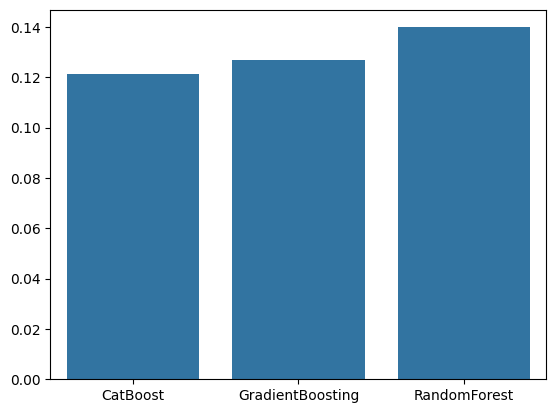

In [60]:
sort_res = dict(sorted(result.items(), key=lambda x: x[1]))
sns.barplot(x=sort_res.keys(), y=sort_res.values())
plt.show()

In [68]:
pool = Pool(pn.concat((X_train, X_test)).sort_index(), pn.concat((y_train, y_test)).sort_index(), cat_features=cat_f)

model = CatBoostRegressor(**CatBoost_params)
model.fit(pool, verbose=100)

0:	learn: 77839.3017868	total: 26.8ms	remaining: 26.8s
100:	learn: 25824.3300242	total: 2.15s	remaining: 19.1s
200:	learn: 19298.4767175	total: 4.48s	remaining: 17.8s
300:	learn: 17108.6445062	total: 10.3s	remaining: 24s
400:	learn: 15705.7709843	total: 13.9s	remaining: 20.8s
500:	learn: 14771.3893724	total: 16.4s	remaining: 16.3s
600:	learn: 13922.3090737	total: 21s	remaining: 13.9s
700:	learn: 12953.6483149	total: 24.7s	remaining: 10.6s
800:	learn: 12195.6225365	total: 27.8s	remaining: 6.92s
900:	learn: 11479.1648063	total: 30.2s	remaining: 3.32s
999:	learn: 10804.0004598	total: 33.9s	remaining: 0us


<h2>Предсказание</h2>

In [70]:
pre_test = preprocessing(test)

In [71]:
y_pred = model.predict(pre_test.drop('Id', axis=1))

In [72]:
out = pn.DataFrame({'Id': test['Id'], 'SalePrice': y_pred})
out.to_csv('baseline_11.csv', index=False)

Качество 0.124